In [1]:
!pip install "/kaggle/input/pyspellchecker/pyspellchecker-0.7.2-py3-none-any.whl"
!pip install /kaggle/input/textstat-pypi/Pyphen-0.9.3-py2.py3-none-any.whl
!pip install /kaggle/input/textstat-pypi/textstat-0.7.0-py3-none-any.whl

Processing /kaggle/input/pyspellchecker/pyspellchecker-0.7.2-py3-none-any.whl
Processing /kaggle/input/textstat-pypi/Pyphen-0.9.3-py2.py3-none-any.whl
Processing /kaggle/input/textstat-pypi/textstat-0.7.0-py3-none-any.whl


In [2]:
import sys

sys.path.append('/kaggle/input/autocorrect-1-1-1-mit/autocorrect/')

In [3]:
from typing import List
import gc
import numpy as np
import pandas as pd
import warnings
import logging
import os
import shutil
import json
import transformers
from transformers import AutoModel, AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from datasets import Dataset,load_dataset, load_from_disk
from transformers import TrainingArguments, Trainer
from datasets import load_metric, disable_progress_bar
from sklearn.metrics import mean_squared_error
import torch
from sklearn.model_selection import KFold, GroupKFold
from tqdm import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
from collections import Counter
import spacy
import re
from autocorrect import Speller
from spellchecker import SpellChecker
import lightgbm as lgb
import textstat


warnings.simplefilter("ignore")
logging.disable(logging.ERROR)
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
disable_progress_bar()
tqdm.pandas()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [4]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(seed=42)

In [5]:
class CFG:
    model_name="deberta-v3-large/deberta-v3-large"
    learning_rate=0.000016   #0.000015
    weight_decay=0.02
    hidden_dropout_prob=0.007
    attention_probs_dropout_prob=0.007
    num_train_epochs=5
    n_splits=4
    batch_size=4
    random_seed=42
    save_steps=100
    max_length=512
    target_cols=['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']
    model = "microsoft/deberta-v3-base"
    path = "../input/0911-deberta-v3-base/"
    base = "../input/fb3models/microsoft-deberta-v3-base/"
    config_path = base + "config/config.json"
    tokenizer = AutoTokenizer.from_pretrained(base + 'tokenizer/')

## Dataload

In [6]:
DATA_DIR = "/kaggle/input/commonlit-evaluate-student-summaries/"

train = pd.read_csv('/kaggle/input/tr-no-correct/train.csv')
db_train = pd.read_csv('/kaggle/input/wts-squad/fold_train.csv')

prompts_test = pd.read_csv(DATA_DIR + "prompts_test.csv")
summaries_test = pd.read_csv(DATA_DIR + "summaries_test.csv")
sample_submission = pd.read_csv(DATA_DIR + "sample_submission.csv")

In [7]:
train['iheb_pred_content_6'] = pd.read_csv('/kaggle/input/training-add-new-baseline/train.csv')['iheb_pred_content_6']
train['iheb_pred_wording_6'] = pd.read_csv('/kaggle/input/training-add-new-baseline/train.csv')['iheb_pred_wording_6']

In [8]:
train['content_pred_squad'] = db_train['content_pred']
train['wording_pred_squad'] = db_train['wording_pred']

## Meta Data

In [9]:
import numpy as np
import pandas as pd
import spacy
from sklearn.preprocessing import LabelEncoder


# Load the SpaCy model
nlp = spacy.load('en_core_web_sm')

def clean_lexile(lexile):
    """
    Function to clean lexile feature
    Args:
        lexile (str or float): The lexile measure as a string or a float

    Returns:
        int or np.nan: The cleaned lexile measure as an integer, or np.nan for 'Non-Prose' or 'nan' values
    """
    if pd.isnull(lexile):
        return np.nan
    elif isinstance(lexile, str):
        if lexile == 'Non-Prose':
            return np.nan
        else:
            # Remove the 'L' at the end and convert to integer
            return int(lexile.rstrip('L'))
    else:
        # If lexile is a float (or any non-string data type), convert to int and return
        return int(lexile)

# Function to classify author type
def classify_author(author):
    # Process the text
    doc = nlp(author)
    
    # Check if any of the entities are labeled as 'PERSON'
    for ent in doc.ents:
        if ent.label_ == 'PERSON':
            return 'person'
            
    # If no 'PERSON' entity is found, return 'org'
    return 'org'


def encode_author_type(df):
    """
    Function to encode author_type feature
    Args:
        df (pd.DataFrame): The DataFrame with 'author_type' column

    Returns:
        pd.DataFrame: The DataFrame with 'author_type' replaced with numerical values
    """
    le = LabelEncoder()
    df['author_type'] = le.fit_transform(df['author_type'])
    return df

def clean_grade(df):
    """
    Function to clean grade feature
    Args:
        df (pd.DataFrame): The DataFrame with 'grade' column

    Returns:
        pd.DataFrame: The DataFrame with 'grade' replaced with integer values
    """
    df['grade'] = df['grade'].astype(str).str.replace('rd Grade', '')
    df['grade'] = df['grade'].str.replace('th Grade', '')
    df['grade'] = df['grade'].apply(lambda x: int(x) if x.isdigit() else 0)
    return df



def group_and_encode_genre(df):
    """
    Function to group and encode genre feature
    Args:
        df (pd.DataFrame): The DataFrame with 'genre' column

    Returns:
        pd.DataFrame: The DataFrame with 'genre' replaced with grouped and encoded values
    """
    genre_map = {
        'Fiction': ['Poem', 'Short Story', 'Folktale', 'Fantasy', 'Science Fiction', 'Allegory', 'Fiction - General', 'Fable', 'Myth', 'Historical Fiction', 'Magical Realism', 'Drama'],
        'Non-Fiction': ['Informational Text', 'Non-Fiction - General', 'Biography', 'Essay', 'Memoir', 'Interview', 'Psychology', 'Primary Source Document', 'Autobiography'],
        'News & Opinion': ['News', 'Opinion'],
        'Historic & Legal': ['Historical Document', 'Legal Document', 'Letter'],
        'Philosophy & Religion': ['Speech', 'Religious Text', 'Satire', 'Political Theory', 'Philosophy']
    }

    # Reverse the genre_map dictionary for mapping
    reverse_genre_map = {genre: key for key, values in genre_map.items() for genre in values}

    df['genre_big_group'] = df['genre'].map(reverse_genre_map)

    # If the genre is not found in the map, assign it to 'Other'
    df['genre_big_group'] = df['genre_big_group'].fillna('Other')

    le = LabelEncoder()
    df['genre_big_group_encode'] = le.fit_transform(df['genre_big_group'])
    
    return df


In [10]:
# Usage
prompt_grade = pd.read_csv(r'/kaggle/input/commonlit-texts/commonlit_texts.csv')
# df = pd.read_csv(r'/kaggle/input/commonlit-texts/commonlit_texts.csv')
prompt_grade['author_type'] = prompt_grade['author'].apply(classify_author)
prompt_grade['lexile_md'] = prompt_grade['lexile'].apply(clean_lexile)
prompt_grade = encode_author_type(prompt_grade)
prompt_grade = clean_grade(prompt_grade)
prompt_grade = group_and_encode_genre(prompt_grade)

In [11]:
prompt_grade.head()

,title,author,description,grade,genre,lexile,path,is_prose,date,intro,excerpt,license,notes,author_type,lexile_md,genre_big_group,genre_big_group_encode
0,"(love song, with two goldfish)",Grace Chua,The speaker describes a love story between two...,8,Poem,NaN,/en/texts/love-song-with-two-goldfish,0,2003,Grace Chua is an award-winning journalist whos...,"[1]\n(He's a drifter,\nA “drifter” is a person...","""(love song, with two goldfish)"" from\n Quarte...",A “drifter” is a person who is continually mov...,1,NaN,Fiction,0
1,10 Things You Can Do to Avoid Fraud,Federal Trade Commission,The Federal Trade Commission discusses what pe...,10,Informational Text,1100.0,/en/texts/10-things-you-can-do-to-avoid-fraud,1,NaN,Whether they come in the form of an email clai...,[1]\nInternational scam artists use clever sch...,"""10 Things You Can Do to Avoid Fraud"" by Feder...",to illegally obtain money from someone\nFoil\n...,0,1100.0,Non-Fiction,3
2,"100 years ago: An election, a virus and a cry ...",Michael E. Ruane,"In 2020, a news reporter takes a look back at ...",11,Informational Text,1140.0,/en/texts/100-years-ago-an-election-a-virus-an...,1,2020,Michael E. Ruane is a general assignment repor...,[1]\nA critical election loomed. The country w...,"""100 years ago: An election, a virus and a cry...",significant decline in economic activity\nStri...,1,1140.0,Non-Fiction,3
3,13 Concussions,Casey Cochran,"In this article, a former college football pla...",9,Informational Text,810.0,/en/texts/13-concussions,1,2016,Casey Cochran played college football at the U...,[1]\nIt was a beautiful night in late August. ...,"""13 Concussions"" from \nThe Players' Tribune\n...",Brigham Young University - the Cougar is their...,1,810.0,Non-Fiction,3
4,The 13th,Shelley Walden,"When the COVID-19 lockdown begins, a superstit...",6,Short Story,700.0,/en/texts/the-13th,1,2021,Superstitions exist in many different cultures...,[1]\nAs Angela stared out the school bus windo...,"""The 13th"" by Shelley Walden. Copyright © 202...",Coincidence\n \n(noun) : \nan event that happe...,1,700.0,Fiction,0


In [12]:
def preprocess_and_join(df1, df2, df1_title_col, df2_title_col, grade_col):
    # Copy dataframes to avoid modifying the originals
    df1 = df1.copy()
    df2 = df2.copy()

    # Preprocess titles
    df1[df1_title_col] = df1[df1_title_col].str.replace('"', '').str.strip()
    df2[df2_title_col] = df2[df2_title_col].str.replace('"', '').str.strip()

    # Remove duplicate grades
    df2 = df2.drop_duplicates(subset=df2_title_col, keep='first')

    # Join dataframes
    merged_df = df1.merge(df2, how='left', left_on=df1_title_col, right_on=df2_title_col)
    

    # Postprocess grades
    merged_df[grade_col] = merged_df[grade_col].fillna(0)
    merged_df[grade_col] = merged_df[grade_col].astype(int).astype('category')

 
    return merged_df

# Usage
DATA_DIR = "/kaggle/input/commonlit-evaluate-student-summaries/"
prompts_train = pd.read_csv(DATA_DIR + "prompts_train.csv")
prompts_test = pd.read_csv(DATA_DIR + "prompts_test.csv")
summaries_train = pd.read_csv(DATA_DIR + "summaries_train.csv")
summaries_test = pd.read_csv(DATA_DIR + "summaries_test.csv")
sample_submission = pd.read_csv(DATA_DIR + "sample_submission.csv")
# prompt_grade = pd.read_csv(r'/kaggle/input/litess-titles/all_titles.csv')
train = preprocess_and_join(train, prompt_grade, 'prompt_title', 'title', 'grade')
prompts_test = preprocess_and_join(prompts_test, prompt_grade, 'prompt_title', 'title', 'grade')

In [13]:
train.head()

,student_id,prompt_id,text,content,wording,summary_length,fixed_summary_text,splling_err_num,prompt_question,prompt_title,...,is_prose,date,intro,excerpt,license,notes,author_type,lexile_md,genre_big_group,genre_big_group_encode
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,64,The third wave was an experimental see how peo...,5,Summarize how the Third Wave developed over su...,The Third Wave,...,1,2015,"In 1967, history teacher Ron Jones conducted a...",Background[1]\nThe Third Wave experiment took ...,© 2015. The Third Wave by CommonLit is license...,"Authoritarian\n \n(adjective) : \nsevere, cont...",0,1260.0,Non-Fiction,3
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,54,They would rub it up with soda to make the sme...,2,Summarize the various ways the factory would u...,Excerpt from The Jungle,...,1,1906,Upton Sinclair (1878-1968) was a famous twenti...,[1]\nWith one member trimming beef in a canner...,Excerpt from \nThe Jungle\n by Upton Sinclair ...,Apparatus\n \n(noun) : \nthe technical equipme...,0,1400.0,Fiction,0
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,269,"In Egypt, there were many occupations and soci...",32,"In complete sentences, summarize the structure...",Egyptian Social Structure,...,1,2016,Ancient Egypt was composed of several social c...,[1]\nEgyptian society was structured like a py...,Egyptian Social Structure by USHistory.org is ...,Ra was the sun god of ancient Egyptian myth an...,0,890.0,Non-Fiction,3
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,28,The highest class was Pharaohs these people we...,5,"In complete sentences, summarize the structure...",Egyptian Social Structure,...,1,2016,Ancient Egypt was composed of several social c...,[1]\nEgyptian society was structured like a py...,Egyptian Social Structure by USHistory.org is ...,Ra was the sun god of ancient Egyptian myth an...,0,890.0,Non-Fiction,3
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,232,The Third Wave developed rapidly because the ...,29,Summarize how the Third Wave developed over su...,The Third Wave,...,1,2015,"In 1967, history teacher Ron Jones conducted a...",Background[1]\nThe Third Wave experiment took ...,© 2015. The Third Wave by CommonLit is license...,"Authoritarian\n \n(adjective) : \nsevere, cont...",0,1260.0,Non-Fiction,3


### Label Encode

In [14]:
from sklearn.preprocessing import LabelEncoder
to_encode = ['genre', 'genre_big_group']


for c in to_encode:
    mapper = dict(zip(train[c].unique(), range(train[c].nunique())))
    train[c] = train[c].map(mapper)
    prompts_test[c] = prompts_test[c].map(mapper)

## Preprocess

[Using features]

- Text Length
- Length Ratio
- Word Overlap
- N-grams Co-occurrence
  - count
  - ratio
- Quotes Overlap
- Grammar Check
  - spelling: pyspellchecker


In [15]:
class Preprocessor:
    def __init__(self, 
                model_name: str,
                ) -> None:
        self.tokenizer = AutoTokenizer.from_pretrained(f"/kaggle/input/{model_name}")
        self.twd = TreebankWordDetokenizer()
        self.STOP_WORDS = set(stopwords.words('english'))
        
        self.spacy_ner_model = spacy.load('en_core_web_sm',)
        self.speller = Speller(lang='en')
        self.spellchecker = SpellChecker() 
        
    def word_overlap_count(self, row):
        """ intersection(prompt_text, text) """        
        def check_is_stop_word(word):
            return word in self.STOP_WORDS
        
        prompt_words = row['prompt_tokens']
        summary_words = row['summary_tokens']
        if self.STOP_WORDS:
            prompt_words = list(filter(check_is_stop_word, prompt_words))
            summary_words = list(filter(check_is_stop_word, summary_words))
        return len(set(prompt_words).intersection(set(summary_words)))
            
    def ngrams(self, token, n):
        # Use the zip function to help us generate n-grams
        # Concatentate the tokens into ngrams and return
        ngrams = zip(*[token[i:] for i in range(n)])
        return [" ".join(ngram) for ngram in ngrams]

    def ngram_co_occurrence(self, row, n: int) -> int:
        # Tokenize the original text and summary into words
        original_tokens = row['prompt_tokens']
        summary_tokens = row['summary_tokens']

        # Generate n-grams for the original text and summary
        original_ngrams = set(self.ngrams(original_tokens, n))
        summary_ngrams = set(self.ngrams(summary_tokens, n))

        # Calculate the number of common n-grams
        common_ngrams = original_ngrams.intersection(summary_ngrams)
        return len(common_ngrams)
    
    def ner_overlap_count(self, row, mode:str):
        model = self.spacy_ner_model
        def clean_ners(ner_list):
            return set([(ner[0].lower(), ner[1]) for ner in ner_list])
        prompt = model(row['prompt_text'])
        summary = model(row['text'])

        if "spacy" in str(model):
            prompt_ner = set([(token.text, token.label_) for token in prompt.ents])
            summary_ner = set([(token.text, token.label_) for token in summary.ents])
        elif "stanza" in str(model):
            prompt_ner = set([(token.text, token.type) for token in prompt.ents])
            summary_ner = set([(token.text, token.type) for token in summary.ents])
        else:
            raise Exception("Model not supported")

        prompt_ner = clean_ners(prompt_ner)
        summary_ner = clean_ners(summary_ner)

        intersecting_ners = prompt_ner.intersection(summary_ner)
        
        ner_dict = dict(Counter([ner[1] for ner in intersecting_ners]))
        
        if mode == "train":
            return ner_dict
        elif mode == "test":
            return {key: ner_dict.get(key) for key in self.ner_keys}
        
    def quotes_count(self, row):
        summary = row['text']
        text = row['prompt_text']
        
        # Find all quotes in the summary
        quotes_from_summary = re.findall(r'"([^"]*)"', summary)
        
        if len(quotes_from_summary) > 0:
            # Count the number of quotes from the summary that appear in the prompt text
            quotes_found_in_prompt = [quote in text for quote in quotes_from_summary]
            quotes_count = sum(quotes_found_in_prompt)
            return quotes_count
        else:
            # If there are no quotes in the summary, return 0
            return 0
        
    def quotes_presence_indicator(self, row):
        summary = row['text']
        text = row['prompt_text']
        
        # Find all quotes in the summary
        quotes_from_summary = re.findall(r'"([^"]*)"', summary)
        
        if len(quotes_from_summary) > 0:
            # Check if any quotes from the summary exist in the prompt text
            return int(any(quote in text for quote in quotes_from_summary))
        else:
            # If there are no quotes in the summary, return 0
            return 0
    
    def quote_length_ratio(self, row):
        summary = row['text']
        
        # Find all quotes in the summary
        quotes_from_summary = re.findall(r'"([^"]*)"', summary)
        
        if len(quotes_from_summary) > 0:
            # Calculate the total length of quotes and the total length of the summary
            total_quote_length = sum(len(quote) for quote in quotes_from_summary)
            total_summary_length = len(summary)
            
            # Calculate the ratio of quote length to summary length
            return total_quote_length / total_summary_length
        else:
            # If there are no quotes in the summary, return 0
            return 0
    
    def quote_position(self, row):
        summary = row['text']
        
        # Find all quotes in the summary
        quotes_from_summary = re.findall(r'"([^"]*)"', summary)
        
        if len(quotes_from_summary) > 0:
            # Calculate the positions of quotes within the summary
            positions = [match.start() for match in re.finditer(r'"([^"]*)"', summary)]
            
            # Calculate the average position of quotes within the summary
            average_position = sum(positions) / len(positions)
            return average_position
        else:
            # If there are no quotes in the summary, return -1 to indicate no quotes
            return -1  # You can choose a suitable placeholder value


    def spelling(self, text):
        
        wordlist=text.split()
        amount_miss = len(list(self.spellchecker.unknown(wordlist)))

        return amount_miss
    
    def add_spelling_dictionary(self, tokens: List[str]) -> List[str]:
        """dictionary update for pyspell checker and autocorrect"""
        self.spellchecker.word_frequency.load_words(tokens)
        self.speller.nlp_data.update({token:1000 for token in tokens})
    
    def run(self, 
            prompts: pd.DataFrame,
            summaries:pd.DataFrame,
            mode:str
        ) -> pd.DataFrame:
        
        # before merge preprocess
        prompts["prompt_length"] = prompts["prompt_text"].apply(
            lambda x: len(word_tokenize(x))
        )
        prompts["prompt_tokens"] = prompts["prompt_text"].apply(
            lambda x: word_tokenize(x)
        )

        summaries["summary_length"] = summaries["text"].apply(
            lambda x: len(word_tokenize(x))
        )
        summaries["summary_tokens"] = summaries["text"].apply(
            lambda x: word_tokenize(x)
        )
        
        # Add prompt tokens into spelling checker dictionary
        prompts["prompt_tokens"].apply(
            lambda x: self.add_spelling_dictionary(x)
        )
        
#         from IPython.core.debugger import Pdb; Pdb().set_trace()
        # fix misspelling
        summaries["fixed_summary_text"] = summaries["text"].progress_apply(
            lambda x: self.speller(x)
        )
        
        # count misspelling
        summaries["splling_err_num"] = summaries["text"].progress_apply(self.spelling)
        
        # merge prompts and summaries
        input_df = summaries.merge(prompts, how="left", on="prompt_id")

        # after merge preprocess
        input_df['length_ratio'] = input_df['summary_length'] / input_df['prompt_length']
        
        input_df['word_overlap_count'] = input_df.progress_apply(self.word_overlap_count, axis=1)
        input_df['bigram_overlap_count'] = input_df.progress_apply(
            self.ngram_co_occurrence,args=(2,), axis=1 
        )
        input_df['bigram_overlap_ratio'] = input_df['bigram_overlap_count'] / (input_df['summary_length'] - 1 + 0.001)
        
        input_df['trigram_overlap_count'] = input_df.progress_apply(
            self.ngram_co_occurrence, args=(3,), axis=1
        )
        input_df['trigram_overlap_ratio'] = input_df['trigram_overlap_count'] / (input_df['summary_length'] - 2)
        
        input_df['quotes_count'] = input_df.progress_apply(self.quotes_count, axis=1)
        
        
#         input_df['quote_presence_indicator'] = input_df.progress_apply(self.quotes_presence_indicator, axis=1)
#         input_df['quote_length_ratio'] = input_df.progress_apply(self.quote_length_ratio, axis=1)
#         input_df['quote_position'] = input_df.progress_apply(self.quote_position, axis=1)
        
        
        return input_df.drop(columns=["summary_tokens", "prompt_tokens"])
    
preprocessor = Preprocessor(model_name=CFG.model_name)

In [16]:
test = preprocessor.run(prompts_test, summaries_test, mode="test")

100%|██████████| 4/4 [00:00<00:00, 2049.75it/s]


In [17]:
test['genre_big_group']

0   NaN
1   NaN
2   NaN
3   NaN
Name: genre_big_group, dtype: float64

## Model Function Definition

In [18]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    rmse = mean_squared_error(labels, predictions, squared=False)
    return {"rmse": rmse}

def compute_mcrmse(eval_pred):
    """
    Calculates mean columnwise root mean squared error
    https://www.kaggle.com/competitions/commonlit-evaluate-student-summaries/overview/evaluation
    """
    preds, labels = eval_pred

    col_rmse = np.sqrt(np.mean((preds - labels) ** 2, axis=0))
    mcrmse = np.mean(col_rmse)

    return {
        "content_rmse": col_rmse[0],
        "wording_rmse": col_rmse[1],
        "mcrmse": mcrmse,
    }

def compt_score(content_true, content_pred, wording_true, wording_pred):
    content_score = mean_squared_error(content_true, content_pred)**(1/2)
    wording_score = mean_squared_error(wording_true, wording_pred)**(1/2)
    
    return (content_score + wording_score)/2

## FB3 Features

In [19]:
from torch import nn
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer.encode_plus(
        text, 
        return_tensors=None, 
        add_special_tokens=True, 
        #max_length=CFG.max_len,
        #pad_to_max_length=True,
        #truncation=True
    )
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


# new for CL
class CommonlitDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['text'].values

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        return inputs
    
# ====================================================
# Model
# ====================================================
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

class MaxPooling(nn.Module):
    def __init__(self):
        super(MaxPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        embeddings = last_hidden_state.clone()
        embeddings[input_mask_expanded == 0] = -1e4
        max_embeddings, _ = torch.max(embeddings, dim = 1)
        return max_embeddings
    
class MinPooling(nn.Module):
    def __init__(self):
        super(MinPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        embeddings = last_hidden_state.clone()
        embeddings[input_mask_expanded == 0] = 1e-4
        min_embeddings, _ = torch.min(embeddings, dim = 1)
        return min_embeddings
        

class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
            self.config.hidden_dropout = 0.
            self.config.hidden_dropout_prob = 0.
            self.config.attention_dropout = 0.
            self.config.attention_probs_dropout_prob = 0.
            LOGGER.info(self.config)
        else:
            self.config = AutoConfig.from_pretrained(config_path, output_hidden_states=True)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.pool = MeanPooling()
        self.fc = nn.Linear(self.config.hidden_size, 6)
        self._init_weights(self.fc)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        feature = self.pool(last_hidden_states, inputs['attention_mask'])
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(feature)
        return output
    
# ====================================================
# inference
# ====================================================
def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in test_loader:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

def get_feedback_feat(data):
    to_df = np.zeros((data.shape[0], len(CFG.target_cols)))
    for _idx, CFG_ in enumerate([CFG]):
        dataset = CommonlitDataset(CFG_, data)
        loader = DataLoader(dataset,
                            batch_size=CFG_.batch_size,
                            shuffle=False,
                            collate_fn=DataCollatorWithPadding(tokenizer=CFG.tokenizer, padding='longest'),
                            num_workers=2, pin_memory=True, drop_last=False)

        predictions = []
        for fold in CFG.trn_fold:
            print('='*10, f'started fold {fold}', '='*10)
            model = CustomModel(CFG, config_path=CFG.config_path, pretrained=False)
            state = torch.load(CFG.path+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth",
                               map_location=torch.device('cpu'))
            model.load_state_dict(state['model'])
            prediction = inference_fn(loader, model, device)
            predictions.append(prediction)
            del prediction
            torch.cuda.empty_cache()
        to_df += np.mean(predictions, axis=0) 
        del model, dataset, loader; gc.collect()
        torch.cuda.empty_cache() 
        
    data[CFG.target_cols] = to_df
    del predictions
    return data

In [20]:
from tqdm.notebook import tqdm

tqdm.pandas()

def get_stat_features(df, text_col="text"):
    df["num_unique_words"] = df[text_col].apply(lambda x: len(set(x.split())))
    df["num_words"] = df[text_col].apply(lambda x: len(x.split()))
    df["num_sentences"] = df[text_col].apply(lambda x: len(x.split('.')))
    #df["isupper"] = df[text_col].apply(lambda x: x[0].isupper())
    #df["mean_num_words"] = df[text_col].apply(lambda x: np.mean([len(e.split()) for e in x.split('.')]))
    #df["mean_num_unique_words"] = df[text_col].apply(lambda x: np.mean([len(set(e.split())) for e in x.split('.')]))
    #df["num_slash"] = df[text_col].apply(lambda x: x.count("\n"))
    #df["paragraph_count"] = train[text_col].apply(lambda x: x.count("\n\n"))
    #df["upper_count"] = df[text_col].apply(lambda x: np.sum([w.isupper() for w in x.split()])/len(x.split()))
    df["syntax_count"] = df[text_col].apply(lambda x: x.count(",") + x.count("-") + x.count(";") + x.count(":"))
        
    #df['automated_readability_index'] = df[text_col].progress_apply(lambda x: textstat.automated_readability_index(x))
    ##df['coleman_liau_index'] = df[text_col].progress_apply(lambda x: textstat.coleman_liau_index(x))
    df['smog_index'] = df[text_col].progress_apply(lambda x: textstat.smog_index(x))
    
    #df['dale_chall_readability_score'] = df[text_col].progress_apply(lambda x: textstat.dale_chall_readability_score(x))
    #df['linsear_write_formula'] = df[text_col].progress_apply(lambda x: textstat.linsear_write_formula(x))
    #df['gunning_fog'] = df[text_col].progress_apply(lambda x: textstat.gunning_fog(x))
    df['text_standard_float'] = df[text_col].progress_apply(lambda x: textstat.text_standard(x, float_output=True))
    #df['spache_readability'] = df[text_col].progress_apply(lambda x: textstat.spache_readability(x))
    #df['rix'] = df[text_col].progress_apply(lambda x: textstat.rix(x))
   # df['lix'] = df[text_col].progress_apply(lambda x: textstat.lix(x))
    
    # new features 
    #df["stopwords_rel"] = df[text_col].progress_apply(lambda x: get_stopwords_rel(x))
    
    return df
    
test = get_stat_features(test)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [21]:
CFG.n_fold=10
CFG.trn_fold=list(range(CFG.n_fold))
from torch.utils.data import Dataset,DataLoader
device = 'cuda'
test = get_feedback_feat(test)

========== started fold 0 ==========


  0%|          | 0/1 [00:00<?, ?it/s]

========== started fold 1 ==========


  0%|          | 0/1 [00:00<?, ?it/s]

========== started fold 2 ==========


  0%|          | 0/1 [00:00<?, ?it/s]

========== started fold 3 ==========


  0%|          | 0/1 [00:00<?, ?it/s]

========== started fold 4 ==========


  0%|          | 0/1 [00:00<?, ?it/s]

========== started fold 5 ==========


  0%|          | 0/1 [00:00<?, ?it/s]

========== started fold 6 ==========


  0%|          | 0/1 [00:00<?, ?it/s]

========== started fold 7 ==========


  0%|          | 0/1 [00:00<?, ?it/s]

========== started fold 8 ==========


  0%|          | 0/1 [00:00<?, ?it/s]

========== started fold 9 ==========


  0%|          | 0/1 [00:00<?, ?it/s]

## Reacher Models

In [22]:
class CustomDataset(Dataset) :
    def __init__(self,df) :
        self.df = df
        self.tokenizer = tokenizer
        
        self.sep =self.tokenizer.sep_token
        self.text = (self.df['prompt_title'] + self.sep
        + self.df["prompt_question"] + self.sep +
        self.df["text"]).values
    
    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=512,
            #padding="max_length", ## New
           # is_split_into_words=True, ## New
        )
        feature_dict = {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
        }

        return feature_dict

from torch import nn
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings
    
class GeMText(nn.Module):
    def __init__(self, dim, cfg, p=3, eps=1e-6):
        super(GeMText, self).__init__()
        self.dim = dim
        self.p = Parameter(torch.ones(1) * p)
        self.eps = eps
        self.feat_mult = 1

    def forward(self, x, attention_mask, input_ids, cfg):
        attention_mask_expanded = attention_mask.unsqueeze(-1).expand(x.shape)
        x = (x.clamp(min=self.eps) * attention_mask_expanded).pow(self.p).sum(self.dim)
        ret = x / attention_mask_expanded.sum(self.dim).clip(min=self.eps)
        ret = ret.pow(1 / self.p)
        return ret
    
class Model(nn.Module):
    def __init__(self,config_path):
        super(Model, self).__init__()
        self.config = torch.load(config_path)
        self.model = AutoModel.from_config(self.config)
        self.pool = MeanPooling()
        self.fc = nn.Sequential(
            nn.Linear(self.config.hidden_size, 2))
        
    def forward(self, ids, mask):        
        out = self.model(input_ids=ids,attention_mask=mask,
                         output_hidden_states=False)
        out = self.pool(out.last_hidden_state, mask)
        #out = self.drop(out)
        out = self.fc(out)
        return out
# ====================================================
# inference
# ====================================================
def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    tk0 = tqdm(test_loader, total=len(test_loader))
    for data in tk0:
        ids = data["input_ids"].to(device, dtype=torch.long)
        mask = data["attention_mask"].to(device, dtype=torch.long)
        with torch.no_grad():
            y_preds = model(ids, mask)
        preds.append(y_preds.to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

### Large

In [23]:
test['iheb_pred_content_1'] = 0
test['iheb_pred_wording_1'] = 0
test['iheb_pred_content_2'] = 0
test['iheb_pred_wording_2'] = 0

test['iheb_pred_content_3'] = 0
test['iheb_pred_wording_3'] = 0

test['iheb_pred_content_6'] = 0
test['iheb_pred_wording_6'] = 0

In [24]:
# Infer
tokenizer = AutoTokenizer.from_pretrained("/kaggle/input/deberta-v3-large-hf-weights")
config_path = "/kaggle/input/commonlit-deberta-large-exp1/config.pth"
test_dataset = CustomDataset(test)
test_loader = DataLoader(test_dataset,
                         batch_size=16,
                         shuffle=False,
                         collate_fn=DataCollatorWithPadding(tokenizer=tokenizer),
                         num_workers=2, pin_memory=True, drop_last=False)

predictions = []
device= 'cuda'
import gc
for fold in range(4):
    model = Model(config_path).to(device)
    
    state = torch.load(f"/kaggle/input/commonlit-deberta-large-exp1/fold_{fold}.bin")
    model.load_state_dict(state)
    prediction = inference_fn(test_loader, model, device)
    predictions.append(prediction)
    del model, state, prediction; gc.collect()
    torch.cuda.empty_cache()
predictions = np.mean(predictions, axis=0)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [25]:
test['iheb_pred_content_1'] = predictions[:,0]
test['iheb_pred_wording_1'] = predictions[:,1]

### Base

In [26]:
## Infer
tokenizer = AutoTokenizer.from_pretrained("/kaggle/input/deberta-v3-base-commonlit/tokenizer")
config_path = "/kaggle/input/deberta-config/config_base.pth"
test_dataset = CustomDataset(test)
test_loader = DataLoader(test_dataset,
                         batch_size=16,
                         shuffle=False,
                         collate_fn=DataCollatorWithPadding(tokenizer=tokenizer),
                         num_workers=2, pin_memory=True, drop_last=False)

predictions = []
device= 'cuda'
import gc
for fold in range(4):
    model = Model(config_path).to(device)
    
    state = torch.load(f"/kaggle/input/baseline-training/fold_{fold}.bin")
    model.load_state_dict(state)
    prediction = inference_fn(test_loader, model, device)
    predictions.append(prediction)
    del model, state, prediction; gc.collect()
    torch.cuda.empty_cache()
predictions = np.mean(predictions, axis=0)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [27]:
test['iheb_pred_content_2'] = predictions[:,0]
test['iheb_pred_wording_2'] = predictions[:,1]

### Custom

In [28]:
class Dataset(Dataset) :
    def __init__(self,df,is_train = True) :
        self.df = df
        self.tokenizer = tokenizer
        self.sep_token = self.tokenizer.sep_token
        self.text = ( '[START_S]' + self.df['text'] + "[END_S]" +self.sep_token + '[START_P]' + self.df['prompt_question']+ self.sep_token+ self.df['prompt_text'] + "[END_P]" ).values
        self.is_train = is_train
    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        
        text = self.text[index]
        
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=816
        )
        feature_dict = {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
        }

        return feature_dict
class CustomModelv2(nn.Module):
    def __init__(self):
        super(CustomModelv2, self).__init__()
        self.drop = nn.Dropout(p=0)
        
        self.config = torch.load("/kaggle/input/commonlit-deberta-customv2-allfolds/config.pth")

        self.model = AutoModel.from_config(self.config)
        self.mpool = ""#GeMText()
        self.fc = nn.Sequential(
            nn.Linear(self.config.hidden_size*2, 2),
        )
    def pool(self, x, attention_mask, input_ids):
        input_ids_expanded = input_ids.clone().unsqueeze(-1).expand(x.shape)
        attention_mask_expanded = torch.zeros_like(input_ids_expanded)
        attention_mask_expanded[
            (input_ids_expanded == tokenizer.convert_tokens_to_ids("[START_P]"))
            | (input_ids_expanded == tokenizer.convert_tokens_to_ids("[END_P]"))
        ] = 1
        sum_features = (x * attention_mask_expanded).sum(1)
        ret = sum_features / attention_mask_expanded.sum(1).clip(min=1e-8)
        return ret
    
    def pool2(self, x, attention_mask, input_ids):
        input_ids_expanded = input_ids.clone().unsqueeze(-1).expand(x.shape)
        attention_mask_expanded = torch.zeros_like(input_ids_expanded)
        attention_mask_expanded[
            (input_ids_expanded == tokenizer.convert_tokens_to_ids("[START_S]"))
            | (input_ids_expanded == tokenizer.convert_tokens_to_ids("[END_S]"))
        ] = 1
        sum_features = (x * attention_mask_expanded).sum(1)
        ret = sum_features / attention_mask_expanded.sum(1).clip(min=1e-8)
        return ret
        
    def forward(self, ids, mask):        
        out = self.model(input_ids=ids,attention_mask=mask,
                         output_hidden_states=False)
   
        prompt_embed = self.pool(out.last_hidden_state, mask, ids)
        summ_embed = self.pool2(out.last_hidden_state, mask, ids)
        feat = torch.cat(
            (
                prompt_embed,
                summ_embed
            ),
            -1
        )
        out = self.fc(feat)
        return out

In [29]:
## Infer
tokenizer = AutoTokenizer.from_pretrained("/kaggle/input/commonlit-deberta-customv2-allfolds")
config_path = "/kaggle/input/deberta-config/config_base.pth"
test_dataset = Dataset(test)
test_loader = DataLoader(test_dataset,
                         batch_size=16,
                         shuffle=False,
                         collate_fn=DataCollatorWithPadding(tokenizer=tokenizer),
                         num_workers=2, pin_memory=True, drop_last=False)

predictions = []
device= 'cuda'
import gc
for fold in range(4):
    model = CustomModelv2().to(device)
    
    state = torch.load(f"/kaggle/input/commonlit-deberta-customv2-allfolds/content_fold_{fold}_seed_42.bin")
    model.load_state_dict(state, strict=False)
    
    prediction = inference_fn(test_loader, model, device)
    predictions.append(prediction)
    del model, state, prediction; gc.collect()
    torch.cuda.empty_cache()
predictions = np.mean(predictions, axis=0)
test['iheb_pred_content_3'] = predictions[:,0]
test['iheb_pred_wording_3'] = predictions[:,1]
del predictions
gc.collect()

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0

### New Baseline

In [30]:
class Dataset(Dataset) :
    def __init__(self,df,is_train = True) :
        self.df = df
        self.tokenizer = tokenizer
        self.sep_token = self.tokenizer.sep_token
        self.text = ( '[START_S]' + self.df['text'] + "[END_S]" + self.sep_token +'[START_P]' + self.df['prompt_question']+ self.sep_token+  self.df['prompt_text'] + "[END_P]" ).values
        self.is_train = is_train
    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        
        text = self.text[index]
        
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=816
        )
        feature_dict = {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
        }

        return feature_dict

class CustomPool(nn.Module):
    def __init__(self, dim=1, p=3, eps=1e-6):
        super(CustomPool, self).__init__()
        self.dim = dim
        self.p = Parameter(torch.ones(1) * p)
        self.eps = eps
        self.feat_mult = 1

    def forward(self, x, attention_mask, input_ids, start_token, end_token):
        input_ids_expanded = input_ids.clone().unsqueeze(-1).expand(x.shape)
        attention_mask_expanded = torch.zeros_like(input_ids_expanded)
        attention_mask_expanded[
            (input_ids_expanded == tokenizer.convert_tokens_to_ids(start_token))
            | (input_ids_expanded == tokenizer.convert_tokens_to_ids(end_token))
        ] = 1
        x = (x.clamp(min=self.eps) * attention_mask_expanded).pow(self.p).sum(self.dim)
        ret = x / attention_mask_expanded.sum(self.dim).clip(min=self.eps)
        ret = ret.pow(1 / self.p)
        return ret
    
class CustomModelv3(nn.Module):
    def __init__(self):
        super(CustomModelv3, self).__init__()
        self.drop = nn.Dropout(p=0)
        
        self.config = torch.load("/kaggle/input/new-baseline-exp1/config.pth")

        self.model = AutoModel.from_config(self.config)
        self.pool = CustomPool()

        self.attention = nn.MultiheadAttention(self.config.hidden_size, num_heads=2)
  
        self.wording = nn.Linear(self.config.hidden_size, 1)
        self.content = nn.Linear(self.config.hidden_size*2, 1)
        


        
    def forward(self, ids, mask):        
        out = self.model(input_ids=ids,attention_mask=mask,
                         output_hidden_states=False)

        prompt_embed = self.pool(out.last_hidden_state, mask, ids, "[START_P]", "[END_P]")
        summ_embed = self.pool(out.last_hidden_state, mask, ids, "[START_S]", "[END_S]")
        feat = torch.cat(
            (
                prompt_embed,
                summ_embed
            ),
            -1
        )
        wor = self.wording(summ_embed)
        con = self.content(feat)
        return torch.cat((con,wor), -1)

In [31]:
## Infer
from torch.nn import Parameter
tokenizer = AutoTokenizer.from_pretrained("/kaggle/input/new-baseline-exp1")
config_path = "/kaggle/input/deberta-config/config_base.pth"
test_dataset = Dataset(test)
test_loader = DataLoader(test_dataset,
                         batch_size=16,
                         shuffle=False,
                         collate_fn=DataCollatorWithPadding(tokenizer=tokenizer),
                         num_workers=2, pin_memory=True, drop_last=False)

predictions = []
device= 'cuda'
import gc
for fold in range(4):
    model = CustomModelv3().to(device)
    
    state = torch.load(f"/kaggle/input/new-baseline-exp1/fold_{fold}.bin")
    model.load_state_dict(state, strict=False)
    
    prediction = inference_fn(test_loader, model, device)
    predictions.append(prediction)
    del model, state, prediction; gc.collect()
    torch.cuda.empty_cache()
predictions = np.mean(predictions, axis=0)
test['iheb_pred_content_6'] = predictions[:,0]
test['iheb_pred_wording_6'] = predictions[:,1]
del predictions
gc.collect()

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0

## Deberta Regressor

In [32]:
class ContentScoreRegressor:
    def __init__(self, 
                model_name: str,
                model_dir: str,
                target: str,
                hidden_dropout_prob: float,
                attention_probs_dropout_prob: float,
                max_length: int,
                ):
        self.inputs = ["prompt_text", "prompt_title", "prompt_question", "fixed_summary_text"]
        self.input_col = "input"
        
        self.text_cols = [self.input_col] 
        self.target = target
        self.target_cols = [target]

        self.model_name = model_name
        self.model_dir = model_dir
        self.max_length = max_length
        
        self.tokenizer = AutoTokenizer.from_pretrained(f"/kaggle/input/{model_name}")
        self.model_config = AutoConfig.from_pretrained(f"/kaggle/input/{model_name}")
        
        self.model_config.update({
            "hidden_dropout_prob": hidden_dropout_prob,
            "attention_probs_dropout_prob": attention_probs_dropout_prob,
            "num_labels": 2,
            "problem_type": "regression",
        })
        
        seed_everything(seed=42)

        self.data_collator = DataCollatorWithPadding(
            tokenizer=self.tokenizer
        )


    def tokenize_function(self, examples: pd.DataFrame):
        labels = [examples[self.target]]
        tokenized = self.tokenizer(examples[self.input_col],
                         padding=False,
                         truncation=True,
                         max_length=self.max_length)
        return {
            **tokenized,
            "labels": labels,
        }
    
    def tokenize_function_test(self, examples: pd.DataFrame):
        tokenized = self.tokenizer(examples[self.input_col],
                         padding=False,
                         truncation=True,
                         max_length=self.max_length)
        return tokenized
        
    def train(self, 
            fold: int,
            train_df: pd.DataFrame,
            valid_df: pd.DataFrame,
            batch_size: int,
            learning_rate: float,
            weight_decay: float,
            num_train_epochs: float,
            save_steps: int,
        ) -> None:
        """fine-tuning"""
        
        sep = self.tokenizer.sep_token
        train_df[self.input_col] = (
                    train_df["prompt_title"] + sep 
                    + train_df["prompt_question"] + sep 
                    + train_df["fixed_summary_text"]
                  )

        valid_df[self.input_col] = (
                    valid_df["prompt_title"] + sep 
                    + valid_df["prompt_question"] + sep 
                    + valid_df["fixed_summary_text"]
                  )
        
        train_df = train_df[[self.input_col] + self.target_cols]
        valid_df = valid_df[[self.input_col] + self.target_cols]
        
        model_content = AutoModelForSequenceClassification.from_pretrained(
            f"/kaggle/input/{self.model_name}", 
            config=self.model_config
        )

        train_dataset = Dataset.from_pandas(train_df, preserve_index=False) 
        val_dataset = Dataset.from_pandas(valid_df, preserve_index=False) 
    
        train_tokenized_datasets = train_dataset.map(self.tokenize_function, batched=False)
        val_tokenized_datasets = val_dataset.map(self.tokenize_function, batched=False)

        # eg. "bert/fold_0/"
        model_fold_dir = os.path.join(self.model_dir, str(fold)) 
        
        training_args = TrainingArguments(
            output_dir=model_fold_dir,
            load_best_model_at_end=True, # select best model
            learning_rate=learning_rate,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=8,
            num_train_epochs=num_train_epochs,
            weight_decay=weight_decay,
            report_to='none',
            greater_is_better=False,
            save_strategy="steps",
            evaluation_strategy="steps",
            eval_steps=save_steps,
            save_steps=save_steps,
            metric_for_best_model="rmse",
            save_total_limit=1
        )

        trainer = Trainer(
            model=model_content,
            args=training_args,
            train_dataset=train_tokenized_datasets,
            eval_dataset=val_tokenized_datasets,
            tokenizer=self.tokenizer,
            compute_metrics=compute_metrics,
            data_collator=self.data_collator
        )

        trainer.train()
        
        model_content.save_pretrained(self.model_dir)
        self.tokenizer.save_pretrained(self.model_dir)

        
    def predict(self, 
                test_df: pd.DataFrame,
                fold: int,
               ):
        """predict content score"""
        
        sep = self.tokenizer.sep_token
        in_text = (
                    test_df["prompt_title"] + sep 
                    + test_df["prompt_question"] + sep 
                    + test_df["fixed_summary_text"]
                  )
        test_df[self.input_col] = in_text

        test_ = test_df[[self.input_col]]
    
        test_dataset = Dataset.from_pandas(test_, preserve_index=False) 
        test_tokenized_dataset = test_dataset.map(self.tokenize_function_test, batched=False)

        model_content = AutoModelForSequenceClassification.from_pretrained(
            f"/kaggle/input/{self.model_name}", 
            config=self.model_config
        )
        model_content.load_state_dict(torch.load(self.model_dir))
        model_content.eval()
        
        # e.g. "bert/fold_0/"
        model_fold_dir = os.path.join('deberta_large', str(fold)) 

        test_args = TrainingArguments(
            output_dir=model_fold_dir,
            do_train = False,
            do_predict = True,
            per_device_eval_batch_size = 4,   
            dataloader_drop_last = False,
        )

        # init trainer
        infer_content = Trainer(
                      model = model_content, 
                      tokenizer=self.tokenizer,
                      data_collator=self.data_collator,
                      args = test_args)

        preds = infer_content.predict(test_tokenized_dataset)[0]

        return preds

In [33]:
def train_by_fold(
        train_df: pd.DataFrame,
        model_name: str,
        target:str,
        save_each_model: bool,
        n_splits: int,
        batch_size: int,
        learning_rate: int,
        hidden_dropout_prob: float,
        attention_probs_dropout_prob: float,
        weight_decay: float,
        num_train_epochs: int,
        save_steps: int,
        max_length:int
    ):

    # delete old model files
    if os.path.exists(model_name):
        shutil.rmtree(model_name)
    
    os.mkdir(model_name)
        
    for fold in range(CFG.n_splits):
        print(f"fold {fold}:")
        
        train_data = train_df[train_df["fold"] != fold]
        valid_data = train_df[train_df["fold"] == fold]
        
        if save_each_model == True:
            model_dir =  f"{target}/{model_name}/fold_{fold}"
        else: 
            model_dir =  f"{model_name}/fold_{fold}"

        csr = ContentScoreRegressor(
            model_name=model_name,
            target=target,
            model_dir = model_dir, 
            hidden_dropout_prob=hidden_dropout_prob,
            attention_probs_dropout_prob=attention_probs_dropout_prob,
            max_length=max_length,
           )
        
        csr.train(
            fold=fold,
            train_df=train_data,
            valid_df=valid_data, 
            batch_size=batch_size,
            learning_rate=learning_rate,
            weight_decay=weight_decay,
            num_train_epochs=num_train_epochs,
            save_steps=save_steps,
        )

def validate(
    train_df: pd.DataFrame,
    target:str,
    save_each_model: bool,
    model_name: str,
    hidden_dropout_prob: float,
    attention_probs_dropout_prob: float,
    max_length : int
    ) -> pd.DataFrame:
    """predict oof data"""
    for fold in range(CFG.n_splits):
        print(f"fold {fold}:")
        
        valid_data = train_df[train_df["fold"] == fold]
        
        model_dir = f'/kaggle/input/wts-deberta-single-model-2/deberta_large_{fold}.pth'
        
        csr = ContentScoreRegressor(
            model_name=model_name,
            target=target,
            model_dir = model_dir,
            hidden_dropout_prob=hidden_dropout_prob,
            attention_probs_dropout_prob=attention_probs_dropout_prob,
            max_length=max_length,
           )
        
        pred = csr.predict(
            test_df=valid_data, 
            fold=fold
        )
        
        train_df.loc[valid_data.index, f"content_pred"] = pred[:, 0]
        train_df.loc[valid_data.index, f"wording_pred"] = pred[:, 1]
            
    return train_df
    
def predict(
    test_df: pd.DataFrame,
    target:str,
    save_each_model: bool,
    model_name: str,
    hidden_dropout_prob: float,
    attention_probs_dropout_prob: float,
    max_length : int
    ):
    """predict using mean folds"""

    for fold in range(CFG.n_splits):
        print(f"fold {fold}:")
        
        model_dir = f'/kaggle/input/wts-deberta-single-model-2/deberta_large_{fold}.pth'
        
        csr = ContentScoreRegressor(
            model_name=model_name,
            target=target,
            model_dir = model_dir, 
            hidden_dropout_prob=hidden_dropout_prob,
            attention_probs_dropout_prob=attention_probs_dropout_prob,
            max_length=max_length,
           )
        
        pred = csr.predict(
            test_df=test_df, 
            fold=fold
        )
        
        test_df[f"content_pred_{fold}"] = pred[:, 0]
        test_df[f"wording_pred_{fold}"] = pred[:, 1]
    
    test_df[f"content_pred"] = test_df[[f"content_pred_{fold}" for fold in range(CFG.n_splits)]].mean(axis=1)
    test_df[f"wording_pred"] = test_df[[f"wording_pred_{fold}" for fold in range(CFG.n_splits)]].mean(axis=1)
        
    return test_df

In [34]:
targets = ['content', 'wording']

In [35]:
from datasets import Dataset,load_dataset, load_from_disk

# for target in ["content", "wording"]:
target = None
test = predict(
    test,
    target=target,
    save_each_model=False,
    model_name=CFG.model_name,
    hidden_dropout_prob=CFG.hidden_dropout_prob,
    attention_probs_dropout_prob=CFG.attention_probs_dropout_prob,
    max_length=CFG.max_length
)

fold 0:


fold 1:


fold 2:


fold 3:


In [36]:
test.head()

,student_id,prompt_id,text,summary_length,fixed_summary_text,splling_err_num,prompt_question,prompt_title,prompt_text,title,...,content_pred_0,wording_pred_0,content_pred_1,wording_pred_1,content_pred_2,wording_pred_2,content_pred_3,wording_pred_3,content_pred,wording_pred
0,000000ffffff,abc123,Example text 1,3,Example text 1,0,Summarize...,Example Title 1,Heading\nText...,NaN,...,-1.755987,-1.626775,-1.723656,-1.397458,-1.680405,-1.263827,-1.612856,-1.495786,-1.693226,-1.445961
1,111111eeeeee,def789,Example text 2,3,Example text 2,0,Summarize...,Example Title 2,Heading\nText...,NaN,...,-1.757542,-1.626400,-1.726721,-1.396168,-1.678763,-1.262823,-1.615588,-1.497192,-1.694654,-1.445646
2,222222cccccc,abc123,Example text 3,3,Example text 3,0,Summarize...,Example Title 1,Heading\nText...,NaN,...,-1.744607,-1.639678,-1.740815,-1.421970,-1.687831,-1.269098,-1.624056,-1.493761,-1.699327,-1.456127
3,333333dddddd,def789,Example text 4,3,Example text 4,0,Summarize...,Example Title 2,Heading\nText...,NaN,...,-1.744961,-1.638561,-1.738802,-1.411025,-1.684719,-1.264807,-1.621455,-1.500666,-1.697484,-1.453765


# Squad

In [37]:
def predict(
    test_df: pd.DataFrame,
    target:str,
    save_each_model: bool,
    model_name: str,
    hidden_dropout_prob: float,
    attention_probs_dropout_prob: float,
    max_length : int
    ):
    """predict using mean folds"""

    for fold in range(CFG.n_splits):
        print(f"fold {fold}:")
        
        model_dir = f'/kaggle/input/wts-squad/deberta_large_{fold}.pth'
        
        csr = ContentScoreRegressor(
            model_name=model_name,
            target=target,
            model_dir = model_dir, 
            hidden_dropout_prob=hidden_dropout_prob,
            attention_probs_dropout_prob=attention_probs_dropout_prob,
            max_length=max_length,
           )
        
        pred = csr.predict(
            test_df=test_df, 
            fold=fold
        )
        
        test_df[f"content_pred_squad{fold}"] = pred[:, 0]
        test_df[f"wording_pred_squad{fold}"] = pred[:, 1]
    
    test_df[f"content_pred_squad"] = test_df[[f"content_pred_squad{fold}" for fold in range(CFG.n_splits)]].mean(axis=1)
    test_df[f"wording_pred_squad"] = test_df[[f"wording_pred_squad{fold}" for fold in range(CFG.n_splits)]].mean(axis=1)
        
    return test_df
# for target in ["content", "wording"]:
target = None
test = predict(
    test,
    target=target,
    save_each_model=False,
    model_name='squaddeb/squad_deberta',
    hidden_dropout_prob=CFG.hidden_dropout_prob,
    attention_probs_dropout_prob=CFG.attention_probs_dropout_prob,
    max_length=CFG.max_length
)

fold 0:


fold 1:


fold 2:


fold 3:


In [38]:
test.head()

,student_id,prompt_id,text,summary_length,fixed_summary_text,splling_err_num,prompt_question,prompt_title,prompt_text,title,...,content_pred_squad0,wording_pred_squad0,content_pred_squad1,wording_pred_squad1,content_pred_squad2,wording_pred_squad2,content_pred_squad3,wording_pred_squad3,content_pred_squad,wording_pred_squad
0,000000ffffff,abc123,Example text 1,3,Example text 1,0,Summarize...,Example Title 1,Heading\nText...,NaN,...,-1.571777,-1.288839,-1.265892,-1.199050,-1.719187,-1.347817,-1.339799,-0.791542,-1.474164,-1.156812
1,111111eeeeee,def789,Example text 2,3,Example text 2,0,Summarize...,Example Title 2,Heading\nText...,NaN,...,-1.571480,-1.295759,-1.336478,-1.248265,-1.722291,-1.386591,-1.376584,-0.837295,-1.501709,-1.191978
2,222222cccccc,abc123,Example text 3,3,Example text 3,0,Summarize...,Example Title 1,Heading\nText...,NaN,...,-1.596536,-1.292149,-1.311480,-1.223518,-1.735080,-1.349368,-1.366221,-0.822585,-1.502329,-1.171905
3,333333dddddd,def789,Example text 4,3,Example text 4,0,Summarize...,Example Title 2,Heading\nText...,NaN,...,-1.581456,-1.270385,-1.313468,-1.224672,-1.740879,-1.359757,-1.352883,-0.840506,-1.497172,-1.173830


## LGBM model

In [39]:
# FEATURES = train.columns

In [40]:
train.description

0       In 1967, a history teacher's social experiment...
1       In this disturbing piece of political fiction,...
2       This informational text describes the social s...
3       This informational text describes the social s...
4       In 1967, a history teacher's social experiment...
                              ...                        
7160    In this disturbing piece of political fiction,...
7161    This informational text describes the social s...
7162    This informational text describes the social s...
7163    This excerpt from Aristotle's famous work "Poe...
7164    In this disturbing piece of political fiction,...
Name: description, Length: 7165, dtype: object

In [41]:
test.select_dtypes(include=['object'])

,student_id,prompt_id,text,fixed_summary_text,prompt_question,prompt_title,prompt_text,title,author,description,path,date,intro,excerpt,license,notes,input
0,000000ffffff,abc123,Example text 1,Example text 1,Summarize...,Example Title 1,Heading\nText...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example Title 1[SEP]Summarize...[SEP]Example t...
1,111111eeeeee,def789,Example text 2,Example text 2,Summarize...,Example Title 2,Heading\nText...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example Title 2[SEP]Summarize...[SEP]Example t...
2,222222cccccc,abc123,Example text 3,Example text 3,Summarize...,Example Title 1,Heading\nText...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example Title 1[SEP]Summarize...[SEP]Example t...
3,333333dddddd,def789,Example text 4,Example text 4,Summarize...,Example Title 2,Heading\nText...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example Title 2[SEP]Summarize...[SEP]Example t...


In [42]:
train['grade'] = train.grade.astype(int)
test['grade'] = test.grade.astype(int)

In [43]:
c_w = [ 0.1126 , 0.5324, -0.02550 , 0.2426 , 0.2235, 0.4235]
columns = [
    train.iheb_pred_content_6,
    train.iheb_pred_content_3,
    train.iheb_pred_content_1,
    train.iheb_pred_content_2,
    train.content_pred,
    train.content_pred_squad
]
test_columns = [
    test.iheb_pred_content_6,
    test.iheb_pred_content_3,
    test.iheb_pred_content_1,
    test.iheb_pred_content_2,
    test.content_pred,
    test.content_pred_squad
]
train['c_blend'] = sum((1/6)*c for w, c in zip(c_w, columns))
test['c_blend'] = sum((1/6)*c for w, c in zip(c_w, test_columns))

In [44]:
c_w = [ 0.20779315,  0.46793504,  0.34587795, -0.06300992,  0.07636666, 0.27636666]
columns = [
    train.iheb_pred_wording_6,
    train.iheb_pred_wording_3,
    train.iheb_pred_wording_1,
    train.iheb_pred_wording_2,
    train.wording_pred,
    train.wording_pred_squad
]
test_columns = [
    test.iheb_pred_wording_6,
    test.iheb_pred_wording_3,
    test.iheb_pred_wording_1,
    test.iheb_pred_wording_2,
    test.wording_pred,
    test.wording_pred_squad
]
train['w_blend'] = sum((1/6)*c for w, c in zip(c_w, columns))
test['w_blend'] = sum((1/6)*c for w, c in zip(c_w, test_columns))

In [45]:
targets = ["content", "wording"]

drop_columns = ["fold", "student_id", "prompt_id", "text", "fixed_summary_text",
                "prompt_question", "prompt_title", 
                "prompt_text", 'description', 'author', 'title', 'path', 'date', 'intro', 'excerpt', 'license', 'notes',
                'iheb_pred_content_6','iheb_pred_wording_6','iheb_pred_content_3','iheb_pred_wording_3','iheb_pred_content_1',
                'iheb_pred_wording_1','iheb_pred_content_2'
               ] + targets
FEATURES = train.columns
FEATURES = [x for x in FEATURES if x not in drop_columns]



In [46]:
len(FEATURES)

37

In [47]:
FEATURES

['summary_length',
 'splling_err_num',
 'prompt_length',
 'length_ratio',
 'word_overlap_count',
 'bigram_overlap_count',
 'bigram_overlap_ratio',
 'trigram_overlap_count',
 'trigram_overlap_ratio',
 'quotes_count',
 'num_unique_words',
 'num_words',
 'num_sentences',
 'syntax_count',
 'smog_index',
 'text_standard_float',
 'cohesion',
 'syntax',
 'vocabulary',
 'phraseology',
 'grammar',
 'conventions',
 'iheb_pred_wording_2',
 'content_pred',
 'wording_pred',
 'content_pred_squad',
 'wording_pred_squad',
 'grade',
 'genre',
 'lexile',
 'is_prose',
 'author_type',
 'lexile_md',
 'genre_big_group',
 'genre_big_group_encode',
 'c_blend',
 'w_blend']

In [48]:
from xgboost import XGBRegressor

In [49]:
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
import gc

model_dict = {}

for target in targets:
    models = []      
    
    for fold in range(CFG.n_splits):
        # Preparation phase
        X_train_cv = train[train["fold"] != fold][FEATURES]
        y_train_cv = train[train["fold"] != fold][target]
        X_eval_cv = train[train["fold"] == fold][FEATURES]
        y_eval_cv = train[train["fold"] == fold][target]
        dtrain = lgb.Dataset(X_train_cv, label=y_train_cv)
        dval = lgb.Dataset(X_eval_cv, label=y_eval_cv)
        
        # LGB Model
        params = {
            'boosting_type': 'gbdt',
            'random_state': 42,
            'objective': 'regression',
            'metric': 'rmse',
            'learning_rate': 0.048,
            'max_depth': 5,
            'lambda_l1': 0.0,
            'lambda_l2': 0.011,
            'n_estimators':5000,
            'feature_fraction':0.5,
        }
        evaluation_results = {}
        model_lgb = lgb.train(
            params, train_set=dtrain, valid_sets=dval, num_boost_round=10000,
            valid_names=['train', 'valid'], 
            callbacks=[
                lgb.early_stopping(stopping_rounds=30, verbose=True),
                lgb.log_evaluation(100),
                lgb.callback.record_evaluation(evaluation_results)
            ]
        )
        models.append(model_lgb)
        del model_lgb, dtrain, dval, evaluation_results
        gc.collect()

        # CatBoost Model
        model_cb = CatBoostRegressor(max_depth=4, learning_rate=0.01, iterations=5000)
        model_cb.fit(X_train_cv, y_train_cv, eval_set=[(X_eval_cv, y_eval_cv)], early_stopping_rounds=90, verbose=100)
        models.append(model_cb)
        del model_cb
        gc.collect()

        # XGBoost Model
        model_xgb = XGBRegressor(max_depth=4, learning_rate=0.01, n_estimators=5000, subsample=0.5)
        model_xgb.fit(X_train_cv, y_train_cv, eval_set=[(X_eval_cv, y_eval_cv)], early_stopping_rounds=90, verbose=100)
        models.append(model_xgb)
        del model_xgb, X_train_cv, y_train_cv, X_eval_cv, y_eval_cv
        gc.collect()

    model_dict[target] = models

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5356
[LightGBM] [Info] Number of data points in the train set: 5108, number of used features: 35
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.017606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best ga

In [50]:
import pandas as pd

def compute_modes(train_target_series, target, bins, num):
    """
    Compute the two most common values of the target for each bin from the training data.
    Returns a dataframe with the bins and their corresponding 1st and 2nd modes.
    """
    # Calculate the target bins for the training data with a distinct name
    bins_col_name = f"{target}_temp_bin"
    train_target_series[bins_col_name] = pd.cut(train_target_series, bins, labels=False)
    
    # Compute the two most common values of the target for each bin
    top_two_modes = train_target_series.groupby(bins_col_name).apply(lambda x: x.value_counts().head(num).index.tolist())
    
    # Split the modes into separate columns
    modes_df = pd.DataFrame(top_two_modes.tolist(), columns=[f"{target}_mode_{x+1}" for x in range(num)], index=top_two_modes.index).reset_index(drop=True)
    return modes_df

def prepare_dataframe(df, target_series, target, bins, modes_df):
    """
    Takes in a dataframe (features only) and a target Series.
    Adds the 1st and 2nd mode features based on the target bin to the input dataframe.
    Returns the modified dataframe.
    """
    
    # Calculate the target bins for the given dataframe
    df_bins = pd.cut(target_series, bins, labels=False)
    
    # Merge the mode information with the given dataframe based on bins
    df = pd.concat([df, modes_df.loc[df_bins].reset_index(drop=True)], axis=1)
    
    return df


# Example usage:

bins_dict = {'content': [-float('inf'), -1.5, -1.2, -1.05, -0.95, -0.50, -0.35, -0.1, 0.0, 0.1, 0.25, 0.3, 0.4, float('inf')],
                 'wording': [-float('inf'), -1.46, -1, -0.5, 0, 0.2, 0.46 ,0.65, 0.9, 1.2, 2, float('inf')]}
modes = {'content': compute_modes(train['content'], 'content', bins_dict['content'], num=2),
         'wording': compute_modes(train['wording'], 'wording', bins_dict['wording'], num=2)}

content_rmse: 0.41252526254533145
wording_rmse: 0.5594545601797273
mcrmse: 0.48598991136252934


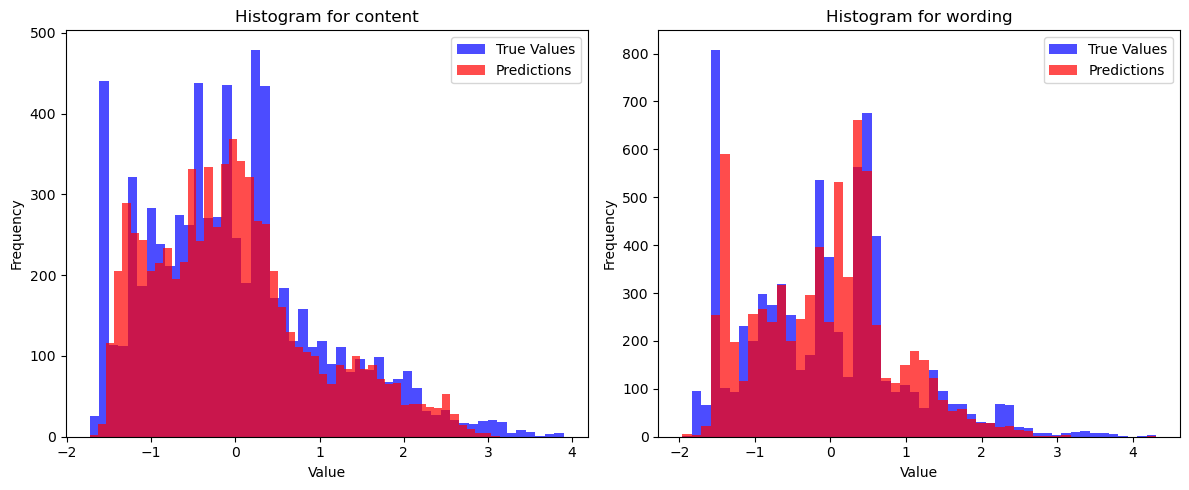

In [51]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from joblib import dump, load

rmses = []
pred_dict = {}
pred_dict_oof = {}

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes = axes.ravel()

for idx, target in enumerate(targets):
    models_list = model_dict[target]

    all_oof_preds = []  # This will store OOF predictions from all models
    trues = []
    all_test_preds = []  # This will store test predictions from all models

    for fold in range(len(models_list) // 3):  # Assuming 3 models per fold
        X_eval_cv = train[train["fold"] == fold][FEATURES]
        y_eval_cv = train[train["fold"] == fold][target]
        trues.extend(y_eval_cv)

        fold_oof_preds = []  
        fold_test_preds = []  

        for i in range(3):
            model = models_list[fold * 3 + i]
            if isinstance(model, lgb.Booster):  # Check if it's LGB Booster
                fold_oof_preds.append(model.predict(X_eval_cv, raw_score=True))
                fold_test_preds.append(model.predict(test[FEATURES], raw_score=True))
            else:
                fold_oof_preds.append(model.predict(X_eval_cv))
                fold_test_preds.append(model.predict(test[FEATURES]))

        # Stack predictions horizontally for this fold
        all_oof_preds.append(np.column_stack(fold_oof_preds))
        all_test_preds.append(np.column_stack(fold_test_preds))
        
        
    import gc
    import ctypes
    libc = ctypes.CDLL("libc.so.6")
    _=gc.collect()
    _=libc.malloc_trim(0)
    _=torch.cuda.empty_cache()

    # Vertical stack to get predictions for all folds
    all_oof_preds = np.vstack(all_oof_preds)
    all_test_preds = np.mean(np.array(all_test_preds), axis=0)

    all_oof_preds = prepare_dataframe(pd.DataFrame(all_oof_preds),np.mean(all_oof_preds,axis=1), target, bins_dict[target],modes[target]).values
    all_test_preds = prepare_dataframe(pd.DataFrame(all_test_preds),np.mean(all_test_preds,axis=1), target, bins_dict[target],modes[target]).values

    # Prepare GroupKFold
    gkf = GroupKFold(n_splits=4)
    enet_oof_preds = np.zeros(all_oof_preds.shape[0])
    enet_test_preds = []

    for i, (train_idx, valid_idx) in enumerate(gkf.split(all_oof_preds, trues, groups=train['prompt_id'])):
        X_train, X_valid = all_oof_preds[train_idx], all_oof_preds[valid_idx]
        y_train, y_valid = np.array(trues)[train_idx], np.array(trues)[valid_idx]

        enet = SVR(kernel='rbf', C=200)
        enet.fit(X_train, y_train)

        enet_oof_preds[valid_idx] = enet.predict(X_valid)
        enet_test_preds.append(enet.predict(all_test_preds))

        del enet

    # Average the test predictions
    test_preds_avg = np.mean(enet_test_preds, axis=0)
    
    enet_oof_preds = np.clip(enet_oof_preds,train[target].min(),train[target].max())
    test_preds_avg = np.clip(test_preds_avg,train[target].min(),train[target].max())
    
    pred_dict[target] = test_preds_avg
    pred_dict_oof[target] = enet_oof_preds
    
    
    
    # Train on Full Data + Psuedo Labeling for test set
    all_test_preds = np.concatenate([all_test_preds,pred_dict[target].reshape(-1,1)],axis=1)
    all_oof_preds = np.concatenate([all_oof_preds,pred_dict_oof[target].reshape(-1,1)],axis=1)
    
    enet = SVR(kernel='rbf', C=45,epsilon=0.15)
    enet.fit(all_oof_preds, np.array(trues))
    pred_dict[target] = np.clip(enet.predict(all_test_preds),train[target].min(),train[target].max())
    
    
    rmse = np.sqrt(mean_squared_error(trues, enet_oof_preds))
    rmses.append(rmse)
    print(f"{target}_rmse: {rmse}")

    # Plot histograms
    axes[idx].hist(trues, bins=50, color='blue', alpha=0.7, label='True Values')
    axes[idx].hist(enet_oof_preds, bins=50, color='red', alpha=0.7, label='Predictions')
    axes[idx].set_title(f'Histogram for {target}')
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()


print(f"mcrmse: {sum(rmses) / len(rmses)}")

plt.tight_layout()
plt.show()

# content_rmse: 0.41092
# wording_rmse: 0.55592
# mcrmse: 0.483422

In [52]:
# remove 6
# content_rmse : 0.42622270470069884
# wording_rmse : 0.5620141385889237
# mcrmse : 0.49411842164481123

# remove 3 & 6
# content_rmse : 0.4241196982233673
# wording_rmse : 0.5587584707894322
# mcrmse : 0.4914390845063997
# remove 3 & 6 & 1
# content_rmse : 0.41834440120904454
# wording_rmse : 0.5613214137741236
# mcrmse : 0.48983290749158404

In [53]:
test = test[['student_id']]
test[['content','wording']] = pd.DataFrame(pred_dict)
del pred_dict

In [54]:
test

,student_id,content,wording
0,000000ffffff,-1.417201,-1.159347
1,111111eeeeee,-1.417087,-1.182596
2,222222cccccc,-1.417463,-1.161761
3,333333dddddd,-1.417472,-1.167160


## Create Submission file

In [55]:
sample_submission

,student_id,content,wording
0,000000ffffff,0.0,0.0
1,111111eeeeee,0.0,0.0
2,222222cccccc,0.0,0.0
3,333333dddddd,0.0,0.0


In [56]:
summary = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/summaries_train.csv')

In [57]:
def rounding(num):
    global col
    round_num, round_num2 = 0, 0
    uniques = np.sort(np.unique(summary[col]))
    for i,n in enumerate(uniques):
        if n > num:
            break
        round_num = n
        try:
            round_num2 = uniques[i+1]
        except:
            round_num2 = uniques[i]
    
    return round_num if (abs(num - round_num) < abs(num - round_num2)) else round_num2

In [58]:
col = 'content'
test[col] = test['content'].apply(rounding)

col = 'wording'
test[col] = test[col].apply(rounding)

In [59]:
test[["student_id", "content", "wording"]].to_csv("submission.csv", index=False)

In [60]:
test[["student_id", "content", "wording"]]

,student_id,content,wording
0,000000ffffff,-1.423877,-1.163138
1,111111eeeeee,-1.423877,-1.173667
2,222222cccccc,-1.423877,-1.163138
3,333333dddddd,-1.423877,-1.166170
